### Objectives: 
    1. Import AquaStat data found on figshare
    2. Map data with folium to determine geographic subset
    3. Subset data to Southwest or Rockies?  Looking for lakes that might overlap with
    MTBS

Used with earth-analytics environment

## 1. Import packages / set working directory

In [1]:
import earthpy as et
import os 
import io
import requests
import feather
import datatools
import folium
import urllib
import json
import numpy as np
#from pandas.io.json import json_normalize
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import warnings
#from shapely.geometry import Point

In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox', 'CU Earth DATA Certificate 2021', 'earthlab_project', 'data')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


## 2. Download the region shapefile 
to use in clipping the MTBS and HydroLAKES dataset

In [3]:
url = 'https://opendata.arcgis.com/datasets/4402a8e032ed49eb8b37fd729e4e8f03_9.geojson'
colo_shp = gpd.read_file(url)

# Make sure appropriate crs for Colorado distances
colo_shp = colo_shp.set_crs(epsg=4326)


## 3.  Define notebook functions

## 4. Read AquaSat dataset 
    1. subset to region of interest
    2. subset to burned lakes from mtbslakes dataset

In [5]:
# Read in aquaSat .csv

#https://figshare.com/
aquasat_url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/18733733/sr_wq_rs_join.csv'
#et.data.get_data(url = aquasat_url)

In [6]:
req = requests.get(aquasat_url)
url_content = req.content
csv_file = open('aquasat.csv', 'wb')

csv_file.write(url_content)
csv_file.close()

In [7]:
input_fp = os.path.join("aquaSat.csv")

shapefile = colo_shp
# For more on reading large csv's in chunks 
#https://towardsdatascience.com/all-the-pandas-read-csv-you-should-know-to-speed-up-your-data-analysis-1e16fe1039f3

#aquasat_co = csv_to_geojson(input_fp, output_fp)
d = pd.read_csv(input_fp, chunksize=50_000)
input_df = pd.concat([x[x['type'].str.startswith('Lak')] for x in d])
#input_df = pd.read_csv(input_fp)


aquasat_colorado = datatools.df_to_gdf(input_df, shapefile)

In [8]:
aquasat_colorado


,system:index,SiteID,blue,blue_sd,date_unity,green,green_sd,nir,nir_sd,path,...,TZID,date_utc,clouds,time,landsat_id,timediff,pwater,type,id,geometry
570271,0,21COL001_WQX-CPW-127,182.0,20.793802,2013-07-18T17:20:00Z,245.000000,32.738085,210.000000,67.694485,31,...,UTC,2013-07-18T17:20:00Z,0.00,2013-07-18T17:20:18Z,LE07_L1TP_031032_20130718_20160910_01_T1,-0.005002,93.0,Lake,New,POINT (-102.27519 40.08423)
570278,0,NARS_WQX-NLA06608-0880,813.0,22.909850,2007-07-17T12:00:00Z,1118.000000,17.796441,592.000000,20.033509,31,...,America/Denver,2007-07-17T18:00:00Z,0.00,2007-07-18T17:15:31Z,LE07_L1TP_031033_20070718_20160922_01_T1,-23.258724,85.0,Lake,New,POINT (-102.19763 39.61349)
570280,1,21COL001_WQX-CPW-166,199.0,10.215389,2015-09-02T21:05:00Z,366.000000,18.589125,140.000000,34.247770,31,...,UTC,2015-09-02T21:05:00Z,1.05,2015-09-02T17:25:32Z,LC08_L1TP_031034_20150902_20170225_01_T1,3.657538,89.0,Lake,New,POINT (-102.37735 37.48790)
570281,2,USGS-380359102561301,396.0,39.695226,1988-06-03T15:24:00Z,499.000000,58.737041,275.000000,26.728727,31,...,UTC,1988-06-03T15:24:00Z,24.00,1988-06-03T16:56:14Z,LT05_L1TP_031034_19880603_20161003_01_T1,-1.537305,97.0,Lake,New,POINT (-102.93742 38.06640)
570293,24,21COL001_WQX-CPW-165,161.0,39.117333,2016-08-02T20:45:00Z,274.470954,98.303059,253.512048,382.842715,31,...,UTC,2016-08-02T20:45:00Z,24.61,2016-08-03T17:25:45Z,LC08_L1TP_031034_20160803_20170222_01_T1,-20.679305,82.0,Lake,New,POINT (-102.63388 38.22017)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580167,704,USGS-391623108501900,867.0,26.410789,2001-04-16T18:35:00Z,1223.000000,43.914409,590.000000,89.902315,36,...,UTC,2001-04-16T18:35:00Z,2.00,2001-04-15T17:46:21Z,LE07_L1TP_036033_20010415_20160930_01_T1,24.810678,97.0,Lake,New,POINT (-108.83927 39.27304)
580168,705,USGS-391623108501900,855.0,31.827246,2002-07-16T15:20:00Z,1106.000000,41.030406,538.000000,76.257259,36,...,UTC,2002-07-16T15:20:00Z,0.00,2002-07-15T17:31:45Z,LT05_L1TP_036033_20020715_20160916_01_T1,21.804009,97.0,Lake,New,POINT (-108.83927 39.27304)
580169,707,USGS-391645108501500,886.0,24.438767,2001-04-16T18:54:00Z,1244.000000,29.967813,590.000000,31.796244,36,...,UTC,2001-04-16T18:54:00Z,2.00,2001-04-15T17:46:21Z,LE07_L1TP_036033_20010415_20160930_01_T1,25.127345,87.0,Lake,New,POINT (-108.83816 39.27915)
580170,708,USGS-391645108501500,909.0,26.709875,2002-07-16T15:29:00Z,1217.000000,29.589105,538.000000,29.892976,36,...,UTC,2002-07-16T15:29:00Z,0.00,2002-07-15T17:31:45Z,LT05_L1TP_036033_20020715_20160916_01_T1,21.954009,87.0,Lake,New,POINT (-108.83816 39.27915)


In [9]:
# Subset this dataframe one more time, extracting only data that align with burned lake dataset created
# in script 1
mtbslakes_fp = os.path.join("whole_burned_lakes.shp")

mtbslakes = gpd.read_file(mtbslakes_fp).to_crs(colo_shp.crs)

aquasat_burn = gpd.overlay(mtbslakes, aquasat_colorado,
                           how='intersection', keep_geom_type=False)

In [10]:
mtbslakes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   distance  49 non-null     float64 
 1   type      49 non-null     object  
 2   Hylak_id  49 non-null     int64   
 3   geometry  49 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 1.7+ KB


In [11]:
aquasat_burn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   distance      75 non-null     float64 
 1   type_1        75 non-null     object  
 2   Hylak_id      75 non-null     int64   
 3   system:index  75 non-null     int64   
 4   SiteID        75 non-null     object  
 5   blue          75 non-null     float64 
 6   blue_sd       74 non-null     float64 
 7   date_unity    75 non-null     object  
 8   green         75 non-null     float64 
 9   green_sd      74 non-null     float64 
 10  nir           75 non-null     float64 
 11  nir_sd        74 non-null     float64 
 12  path          75 non-null     int64   
 13  pixelCount    75 non-null     int64   
 14  qa            75 non-null     float64 
 15  qa_sd         74 non-null     float64 
 16  red           75 non-null     float64 
 17  red_sd        74 non-null     float64 
 18  row 

[None]

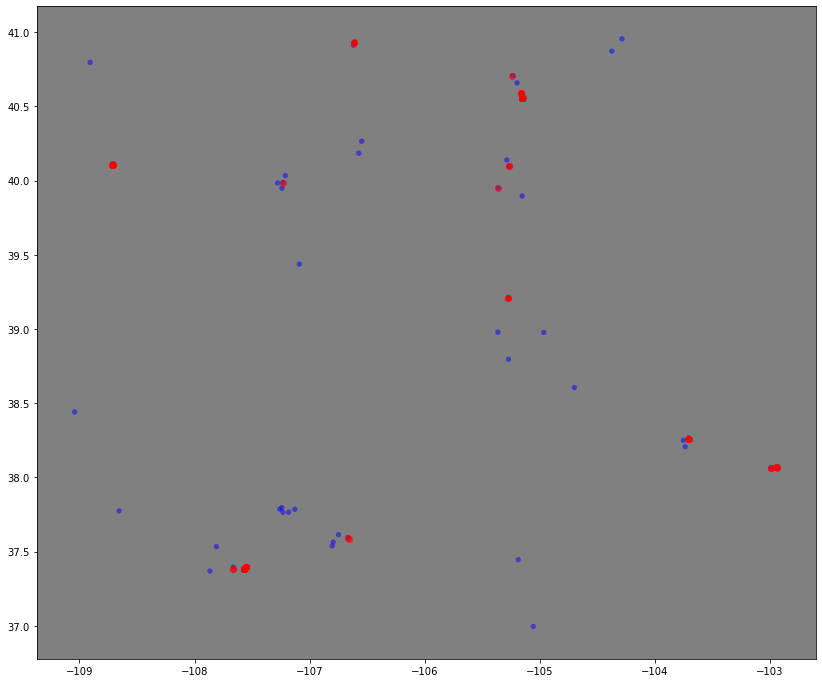

In [12]:
# plot subsets
fig, ax = plt.subplots(figsize=(16, 12))

mtbslakes['geometry'].plot(ax=ax, 
                color='blue', 
                alpha=0.5);

#aquasat_colorado['geometry'].plot(ax=ax, color = 'lime');

aquasat_burn['geometry'].plot(ax=ax, color = 'red',
                             alpha = 0.5);


ax.set(facecolor = "grey")
#.set_axis_off()

In [13]:
# Stamen Terrain
map = folium.Map(location = [39,-105.7], tiles = "Stamen Terrain", zoom_start = 7)
map

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in aquasat_burn.geometry ]

i = 0
for coordinates in geo_df_list:
    map.add_child(folium.Marker(location = coordinates,
                            popup =
                            "Hylak_id: " + str(aquasat_burn.Hylak_id[i]) + '<br>' +
                            "ChlA: " + str(aquasat_burn.chl_a[i]) + '<br>' +
                            "Coordinates: " + str(geo_df_list[i]),
                            icon = folium.Icon(color = 'green')))
    i = i + 1

    
for _, r in mtbslakes.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'blue'})
    #folium.Popup(r['Hylak_id']).add_to(geo_j)
    geo_j.add_child(folium.Popup(r['Hylak_id']))
    geo_j.add_to(map)
map

# #    for _, r in aquasat_burn.iterrows():
#     #sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': 'orange'})
#     folium.Popup(r['Hylak_id']).add_to(geo_j)
#     geo_j.add_to(map)
map

Now aquasat_burn is a dataset of burned lakes with chla and landsat/color data. Classify landsat/color data as pre-or-post fire and determine if any lakes have both.

In [14]:
# Bring in mtbs data (whole_burned_lakes is HydroLakes and LimnoSat data)
in_path = os.path.join("landsat_n_burnpolys.shp")
landsat_n_burnpolys = gpd.read_file(in_path, bbox=colo_shp).to_crs(colo_shp.crs)



/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [15]:
# Make sure Hylak_id is an integer to match aquasat_burn
landsat_n_burnpolys.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33540 entries, 0 to 33539
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Hylak_id    33540 non-null  int64   
 1   LandsatID   33540 non-null  object  
 2   date        33540 non-null  object  
 3   Aerosol     33540 non-null  float64 
 4   Blue        33540 non-null  float64 
 5   Red         33540 non-null  float64 
 6   Green       33540 non-null  float64 
 7   Nir         33540 non-null  float64 
 8   Swir1       33540 non-null  float64 
 9   Swir2       33540 non-null  float64 
 10  TIR1        33540 non-null  float64 
 11  TIR2        33540 non-null  float64 
 12  sat         33540 non-null  object  
 13  pCount_dsw  33540 non-null  float64 
 14  pCount_d_1  33540 non-null  float64 
 15  year        33540 non-null  int64   
 16  dWL         33540 non-null  float64 
 17  distance    33540 non-null  float64 
 18  type        33540 non-null  object  
 

Both aquasat_burn and landsat_n_burnpolys contain the Hylak_id unique identifier.
Merge these datasets based on Hylak_id (subsetting landsat-n-burnpolys to those with 
insitu data)

In [ ]:
# Conversion of shared column to integer and index before merging (makes merge faster)

landsat_n_burnpolys = landsat_n_burnpolys.set_index(['Hylak_id'])
aquasat_burn= aquasat_burn.set_index(['Hylak_id'])

In [23]:

# Shorten limnosat to only lakes desired, makes merge faster
#subset_burned_lakes = landsat_n_burnpolys[landsat_n_burnpolys.index.isin(
#    aquasat_burn.index)]  # subset LimnoSat to lake IDs found in CO HydroLAKES points

# Merge with `merge` method on shared variable (Hylak_id):
insitu_burned_lakes = landsat_n_burnpolys.merge(aquasat_burn, on='Hylak_id')

insitu_burned_lakes.reset_index(inplace=True)
insitu_burned_lakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88795 entries, 0 to 88794
Data columns (total 88 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Hylak_id      88795 non-null  int64   
 1   LandsatID     88795 non-null  object  
 2   date_x        88795 non-null  object  
 3   Aerosol       88795 non-null  float64 
 4   Blue          88795 non-null  float64 
 5   Red           88795 non-null  float64 
 6   Green         88795 non-null  float64 
 7   Nir           88795 non-null  float64 
 8   Swir1         88795 non-null  float64 
 9   Swir2         88795 non-null  float64 
 10  TIR1          88795 non-null  float64 
 11  TIR2          88795 non-null  float64 
 12  sat_x         88795 non-null  object  
 13  pCount_dsw    88795 non-null  float64 
 14  pCount_d_1    88795 non-null  float64 
 15  year          88795 non-null  int64   
 16  dWL           88795 non-null  float64 
 17  distance_x    88795 non-null  float64 
 18  type  

In [24]:
# Generate pre or post fire classification of Landsat imagery based on condition
# that image date is before ingition date

# Convert objects to dates
#insitu_burned_lakes['date_unity'] =insitu_burned_lakes['date_unity'].strftime("%B %d, %Y")
insitu_burned_lakes['date_unity'] = pd.to_datetime(insitu_burned_lakes['date_unity']).dt.tz_localize(None)
insitu_burned_lakes['Ig_Date'] = pd.to_datetime(insitu_burned_lakes['Ig_Date'])
insitu_burned_lakes.date_unity
#insitu_burned_lakes.Ig_Date

0       1988-06-03 15:24:00
1       2006-08-31 17:30:00
2       2006-07-13 18:55:00
3       2015-05-05 18:00:00
4       1988-06-03 15:24:00
                ...        
88790   1985-10-21 18:35:00
88791   2016-07-13 15:45:00
88792   2016-09-14 16:00:00
88793   2006-07-25 22:15:00
88794   2014-09-02 23:59:00
Name: date_unity, Length: 88795, dtype: datetime64[ns]

In [25]:
insitu_burned_lakes['pre_post'] = np.where(
    insitu_burned_lakes['date_unity'] < insitu_burned_lakes['Ig_Date'], "pre-fire", "post-fire")
# print(colo_tabular.pre_post)

# Generate a calculation for the lapse of time pre- or post fire for plotting
insitu_burned_lakes['days_since'] = (insitu_burned_lakes['date_unity'] - insitu_burned_lakes['Ig_Date'])

# Convert days_since to numerical/integer value that can be plotted
insitu_burned_lakes.days_since = insitu_burned_lakes.days_since.astype(
    'timedelta64[D]').astype(int)
# print(insitu_burned_lakes.days_since)

# Add a image month column for trend monitoring
insitu_burned_lakes['img_month'] = pd.DatetimeIndex(insitu_burned_lakes['date_unity']).month

# Add a classification that identifies the number of years since the fire.
# This method allows for manual adjustment of year assingment
col = insitu_burned_lakes['days_since']
conditions = [(col < 2920) & (col >= 2555),
              (col < 2555) & (col >= 2190),
              (col < 2190) & (col >= 1825),
              (col < 1825) & (col >= 1460),
              (col < 1460) & (col >= 1095),
              (col < 1095) & (col >= 730),
              (col < 730) & (col >= 365),
              (col >= 0) & (col < 365),
              (col < 0) & (col >= -365),
              (col < -365) & (col >= -730),
              (col < -703) & (col >= -1095),
              (col < -1095) & (col >= -1460),
              (col < -1460) & (col >= -1825),
              (col < -1825) | (col >= -2190),
              (col < -2190) | (col >= -2555),
              (col < -2555) | (col >= -2920)]
choices = ['8', '7', '6', '5', '4', '3', '2', '1',
           '0', '-1', '-2', '-3', '-4', '-5', '-6', '-7']
insitu_burned_lakes['years_since'] = np.select(conditions, choices, default='meh')
insitu_burned_lakes['years_since'] = insitu_burned_lakes['years_since'].astype(int)

In [42]:
col = insitu_burned_lakes['dWL']
conditions = [(col == 583) & (col > 581),
              (col <= 581) & (col > 579),
              (col <= 579) & (col > 577),
              (col <= 577) & (col > 575),
              (col <= 575) & (col > 573),
              (col <= 573) & (col > 571),
              (col <= 571) & (col > 570),
              (col <= 570) & (col > 569),
              (col <= 569) & (col > 568),
              (col <= 568) & (col > 567),
              (col <= 567) & (col > 564),
              (col <= 564) & (col > 559),
              (col <= 559) & (col > 549),
              (col <= 549) & (col > 530),
              (col <= 530) & (col > 509),
              (col <= 509) & (col > 495),
              (col <= 495) & (col > 489),
              (col <= 489) & (col > 485),
              (col <= 485) & (col > 480),
              (col <= 480) & (col > 475),
              (col > 470) & (col <= 475)]


choices = ['21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11',
           '10', '9', '8', '7', '6', '5', '4', '3', '2', '1']
insitu_burned_lakes['fui'] = np.select(conditions, choices, default='1001')
insitu_burned_lakes['fui'] = pd.to_numeric(insitu_burned_lakes['fui'], errors='coerce')

choices = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
           'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
insitu_burned_lakes['fui_color'] = np.select(conditions, choices, default='v')

# Check that new or converted values make sense
insitu_burned_lakes[['Ig_Date', 'pre_post',
              'days_since', 'img_month', 'years_since', 'dWL', 'fui']].head

# colo_tabular.dtypes

<bound method NDFrame.head of          Ig_Date   pre_post  days_since  img_month  years_since    dWL  fui
0     2011-04-07   pre-fire       -8343          6           -5  557.0    9
1     2011-04-07   pre-fire       -1680          8           -4  557.0    9
2     2011-04-07   pre-fire       -1729          7           -4  557.0    9
3     2011-04-07  post-fire        1489          5            5  557.0    9
4     2011-04-07   pre-fire       -8343          6           -5  568.0   12
...          ...        ...         ...        ...          ...    ...  ...
88790 2000-05-28   pre-fire       -5333         10           -5  556.0    9
88791 2000-05-28  post-fire        5890          7           -5  556.0    9
88792 2000-05-28  post-fire        5953          9           -5  556.0    9
88793 2000-05-28  post-fire        2249          7            7  556.0    9
88794 2000-05-28  post-fire        5210          9           -5  556.0    9

[88795 rows x 7 columns]>

In [37]:
insitu_burned_lakes.Incid_Name.unique()

array(['FT. LYONS', 'ORDWAY CROWLEY CO', 'GALENA FIRE', 'ELDORADO',
       'HIGH PARK', 'PICNIC ROCK', 'OLD STAGE', 'SCHOONOVER', 'HAYMAN',
       'BEAVER CREEK', 'MILLION', 'VALLECITO', 'MISSIONARY RIDGE',
       'BIG FISH', 'TAYLOR'], dtype=object)

In [43]:
#insitu_burned_lakes.info()

In [44]:
# Export 
# Export file to local drive
out_path = os.path.join("burned_lakes_color_and_insitu.csv")
insitu_burned_lakes.to_csv(out_path)


## 5. Plots
Let's plot this and look at pre and post fire data

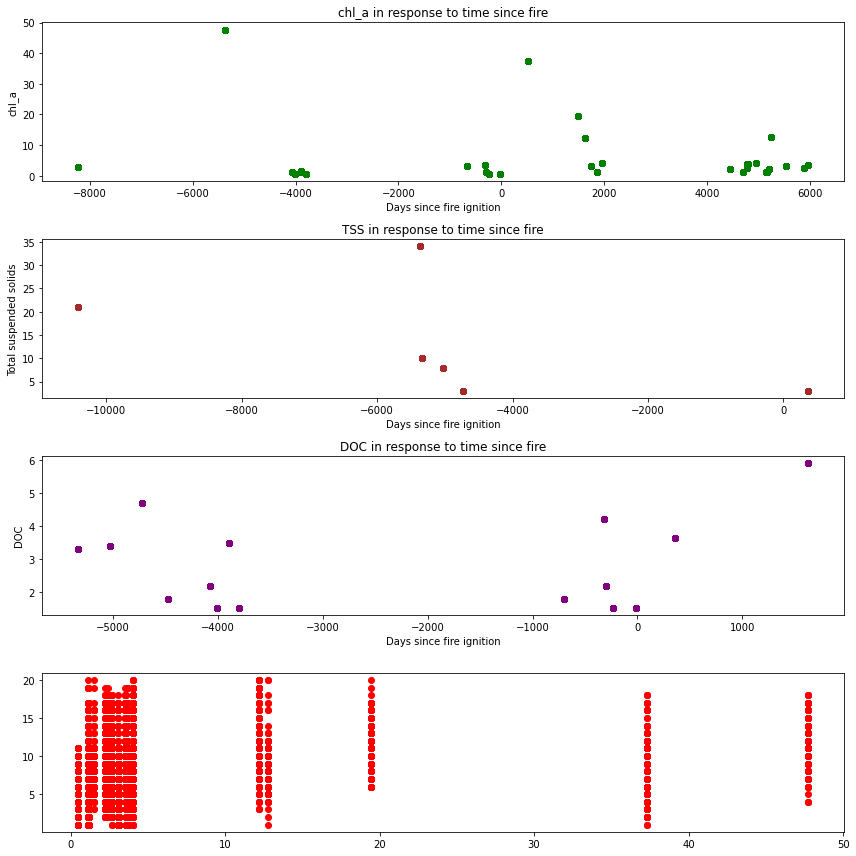

In [62]:
plot_subset = insitu_burned_lakes.loc[(insitu_burned_lakes['fui'] != 1001)]

# Plot 1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

ax1.scatter(x=plot_subset['days_since'],
            y=plot_subset['chl_a'],
            color='green')
ax1.set(title='chl_a in response to time since fire',
       xlabel='Days since fire ignition',
       ylabel='chl_a')



# Plot 2
ax2.scatter(x=plot_subset['days_since'],
            y=plot_subset['tss'],
            color='brown')
ax2.set(title='TSS in response to time since fire',
       xlabel='Days since fire ignition',
       ylabel='Total suspended solids')

# Plot 3
ax3.scatter(x=plot_subset['days_since'],
            y=plot_subset['doc'],
            color='purple')
ax3.set(title='DOC in response to time since fire',
       xlabel='Days since fire ignition',
       ylabel='DOC')



# Plot 4
ax4.scatter(x=plot_subset['chl_a'],
            y=plot_subset['fui'],
            color='red')


plt.tight_layout()